# Mownit lab2

### Import bibliotek

In [2]:
from math import exp, sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np

### Moja wersja funkcji:

In [3]:
#f7, k=3, m=2, [-pi, 2pi]
def f(x):
    return exp(-3 * sin(2*x)) + 3 * cos(2*x)

In [4]:
x_start = -pi
x_end = 2*pi

## Interpolacja Lagrange

In [5]:
def Chebyshev_node(k, n):
    return 0.5*(x_start + x_end) + 0.5*(x_end - x_start) * cos(pi * (2*k+1) * (1/(2*n)))
def even_node(i, n):
    return x_start + i * (x_end - x_start)/(n-1)

def build_xy_data(points_number, nodes_method):
    x_points = [0] * points_number
    y_points = [0] * points_number
    for i in range(points_number):
        x_points[i] = nodes_method(i, points_number)
        y_points[i] = f(x_points[i])
    return x_points, y_points

In [6]:
build_xy_data(3,Chebyshev_node)

([5.651844896321887, 1.5707963267948968, -2.5102522427320926],
 [18.34898564633229, -1.9999999999999991, 0.9671323793121457])

In [7]:
def newton_coefficient(xs, ys):
    m = len(xs)

    xs = np.copy(xs)
    a = np.copy(ys)
    for k in range(1, m):
        a[k:m] = (a[k:m] - a[k - 1])/(xs[k:m] - xs[k - 1])

    return a

def eval_lagrange(xs, ys, x):
    n = len(xs)
    y_eval = 0
    for i in range(n):
        p = 1
        for j in range(n):
            if i != j:
                p *=  (x - xs[j])/(xs[i] - xs[j])

        y_eval += p * ys[i] 
    return y_eval

def eval_newton(xs, ys, x):
    b = newton_coefficient(xs, ys)
    n = len(xs)-1
    y_eval = b[n]
    for k in range(1, n + 1):
        y_eval = b[n - k] + (x - xs[n - k])*y_eval

    return y_eval
    

### Proste testy

In [8]:
xs, ys = build_xy_data(100,Chebyshev_node)
x_e = 0
y_e = eval_lagrange(xs, ys, x_e)

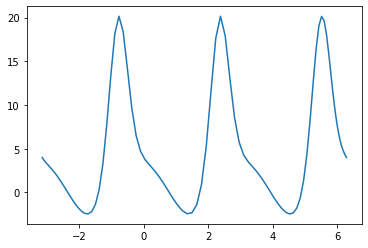

In [9]:
plt.plot(xs,ys)
plt.plot(x_e,y_e)

### Wizualizacja interpolacji

In [10]:
def gen_points(int_fun, xs, ys, n):
    x_delta = (x_end - x_start)/(n-1)
    xt = []
    yt = []
    for i in range(n):
        x = x_start + i * x_delta
        xt.append(x)
        yt.append(int_fun(xs,ys,x))
    return xt, yt

In [11]:
def visualize(n, node_method, eval_method):
    xs, ys = build_xy_data(n,node_method)
    xt, yt = gen_points(eval_method, xs, ys, 100)
    plt.plot(xt,yt)
    xp,yp = build_xy_data(100,even_node)
    plt.plot(xp,yp)

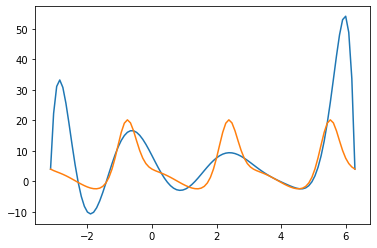

In [31]:
visualize(12,even_node,eval_newton)

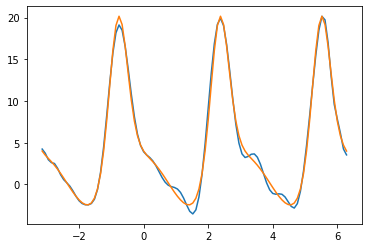

In [41]:
visualize(30,Chebyshev_node,eval_lagrange)

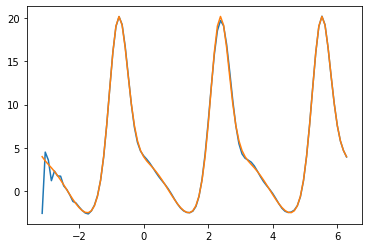

In [14]:
visualize(40,Chebyshev_node,eval_newton)

## Wyliczanie błędów w obliczeniach

In [15]:
def diff(n, test_m, node_m, eval_m):
    xs, ys = build_xy_data(n,node_m)
    xt, yt = gen_points(eval_m, xs, ys, 100)
    xp, yp = build_xy_data(100,even_node)
    return test_m([abs(yp[i]-yt[i]) for i in range(len(yp))])

In [16]:
diff(40,max,Chebyshev_node, eval_lagrange)

0.560790790124539

In [17]:
diff(40,max,Chebyshev_node, eval_newton)

6.528125879612071

In [18]:
diff(40,np.mean,Chebyshev_node, eval_newton)

0.19976215230536518

## Wizualizacja zależności błędu od liczby węzłów

In [52]:
def visualize_diff(test_m, node_m, eval_m):
    start_n = 25
    end_n = 40
    xn = [i for i in range(start_n, end_n+1)]
    yn = [diff(i, test_m, node_m, eval_m) for i in range(start_n, end_n+1)]
    plt.plot(xn,yn)
    plt.xticks(xn)

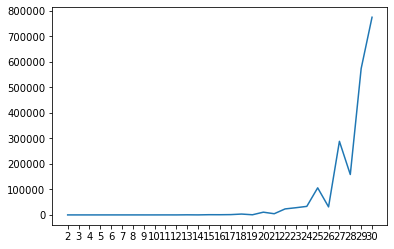

In [47]:
visualize_diff(max,even_node, eval_lagrange)

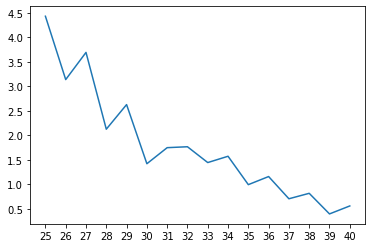

In [53]:
visualize_diff(max,Chebyshev_node, eval_lagrange)